# ERA Interim Climatology

This script analyzes and visualizes the ERA Interim data on which the simulations will be based. The objective of this script is to identify reasonable distributions for water vapor and temperature profiles so that the prior distributions can be expressed in closed form. This is necessary to ensure that the true a posteriori distribution can be approximated with MCMC simulations.

In [2]:
import matplotlib_settings
import matplotlib.pyplot as plt
import numpy as np

## Scalar Data

In terms of scalar data, sea surface temperature and integrated column water vapor will be used. The sea surface temperature is used as input variable for the simulations.

The distribution of column water vapor is not used directly in the simulations, but will be useful to evaluate the resulting training data against.

In [2]:
from netCDF4 import Dataset
rootgrp = Dataset("era_interim_mid_latitudes_2016_sst_cwv.nc")
sst_grid = rootgrp.variables['sst']
cwv_grid = rootgrp.variables['tcwv']
lat     = rootgrp.variables['latitude']
lon     = rootgrp.variables['longitude']

### Sea Surface Temperature

In [3]:
sst_mean_grid = np.mean(sst_grid, axis = 0)
sst_mean_grid.mask = sst_mean_grid == sst_mean_grid.fill_value
sst_mean  = np.mean(sst_mean_grid)
sst_sigma = np.std(np.asarray(sst_grid)[np.logical_not(sst_grid == sst_grid.missing_value)])

np.save("data/sst_mean", sst_mean)
np.save("data/sst_sigma", sst_sigma)

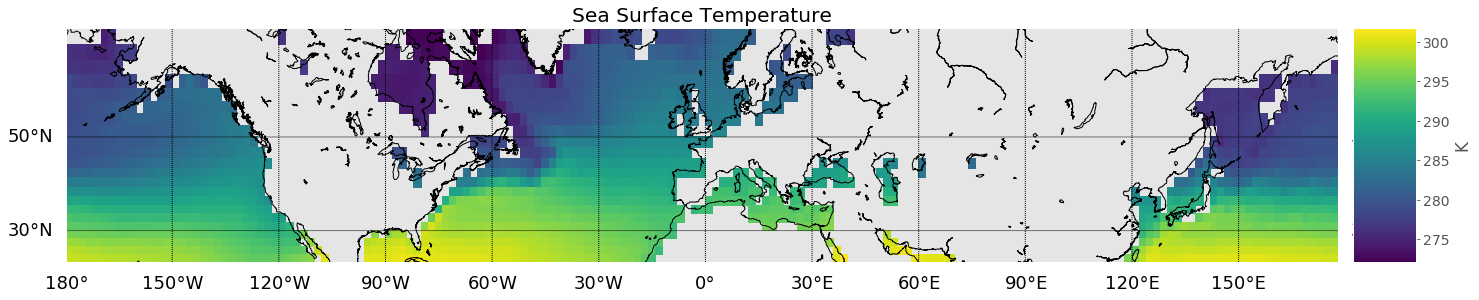

In [4]:
from ipywidgets import interact, interactive
from mpl_toolkits.basemap import Basemap

def plot_color_map(z, title, unit = None):
    fig = plt.figure(figsize = (20, 8))
    llat = np.min(lat)
    ulat = np.max(lat)
    llon = np.min(lon)
    ulon = np.max(lon)
    m = Basemap(llcrnrlon = llon, llcrnrlat = llat, urcrnrlon = ulon, urcrnrlat = ulat,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)
    m.drawcoastlines()
    LON, LAT = np.meshgrid(lon, lat)
    x, y = m(LON, LAT)
    mappable = plt.gca().pcolormesh(x, y, z)
    m.drawparallels(np.arange(10, 90, 20),
                    labels=[1, 1, 0, 1],
                    fontsize = 18)
    m.drawmeridians(np.arange(-180, 180, 30),
                    labels = [1, 1, 0, 1],
                    fontsize = 18)
    
    plt.gca().set_title(title)
    m.colorbar(mappable, pad=0.2, label = unit)
    plt.tight_layout()
    
plot_color_map(sst_mean_grid, "Sea Surface Temperature", unit = "K")

### Column Water Vapor

In [5]:
cwv_grid_mean = np.mean(cwv_grid, axis = 0)
cwv_mean  = np.mean(cwv_grid_mean)

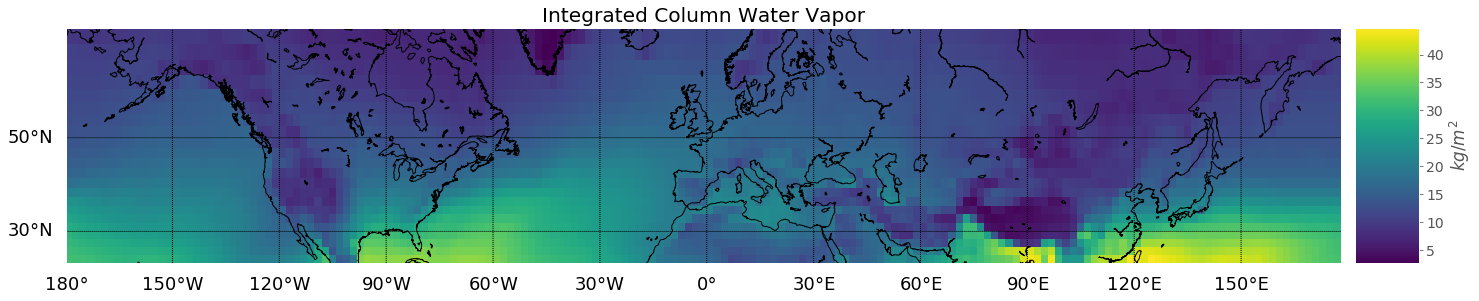

In [6]:
plot_color_map(cwv_grid_mean, "Integrated Column Water Vapor", unit = "$kg / m^2$")

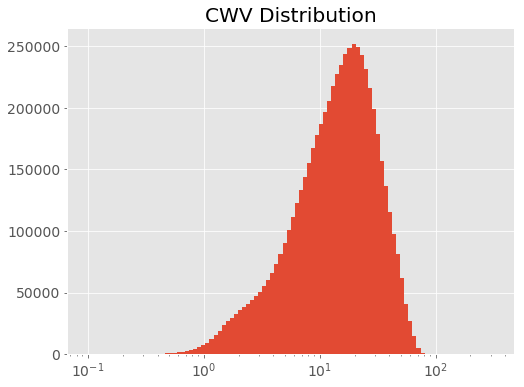

In [7]:
bins = np.logspace(-1, 2.5, 101)
plt.hist(np.asarray(cwv_grid).ravel(), bins = bins)
plt.xscale("log")
plt.title("CWV Distribution")

## Atmospheric Profiles

The radiative transfer simulations are performed in one dimension and the atmospheric state is fully described by the corresponding **temperature** and **water vapor** profiles.

In [4]:
from netCDF4 import Dataset
rootgrp = Dataset("data/era_interim_mid_latitudes_2016.nc")
level   = rootgrp.variables['level']
lat     = rootgrp.variables['latitude']
lon     = rootgrp.variables['longitude']
q_grid  = rootgrp.variables['q']
t_grid  = rootgrp.variables['t']

### Pressure Grid

We interpolate the pressure grid to a uniform grid with 15 points.

In [21]:
p = rootgrp.variables['level']
p_array = np.array(p)
p_interp = np.interp(np.linspace(p[0], p[-1], 15), p_array, p_array)
np.save("data/p_grid", p_interp)

### Extraction of Profiles

In [7]:
def running_mean_2(x):
    res = np.copy(x)
    cs = np.cumsum(x)
    res[1:-1] = 0.5 * (cs[2:] - cs[:-2])
    return res

In [8]:
n_levels = p_interp.shape[0]
q_profiles = np.zeros((q_grid.shape[0] * q_grid.shape[2] * q_grid.shape[3], n_levels))
t_profiles = np.zeros((t_grid.shape[0] * t_grid.shape[2] * t_grid.shape[3], n_levels))

p_smooth = running_mean_2(p)

ind = 0
for i in range(q_grid.shape[0]):
    for j in range(q_grid.shape[2]):
        for k in range(q_grid.shape[3]):
            q_smooth = running_mean_2(q_grid[i, :, j, k].ravel())
            q_profiles[ind, :]  = np.interp(p_interp, p_smooth, q_smooth)
            t_smooth = running_mean_2(t_grid[i, :, j, k].ravel())
            t_profiles[ind, :]  = np.interp(p_interp, p_smooth, t_smooth)
            ind += 1
            
np.save("data/q_profiles", q_profiles)
np.save("data/t_profiles", t_profiles)

In [58]:
q_profiles  = np.load("data/q_profiles.npy")
t_profiles  = np.load("data/t_profiles.npy")

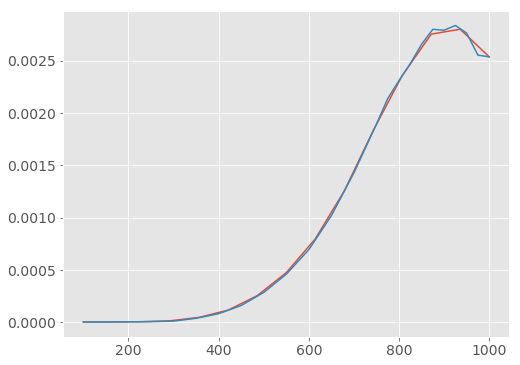

In [48]:
plt.plot(p_interp, q_profiles[5, :])
plt.plot(p, q_grid[0, :, 0, 5].ravel())

### Mean Profiles

In [9]:
q_mean  = np.mean(q_profiles, axis = 0)
t_mean  = np.mean(t_profiles, axis = 0)

np.save("data/q_mean",  q_mean)
np.save("data/t_mean",  t_mean)

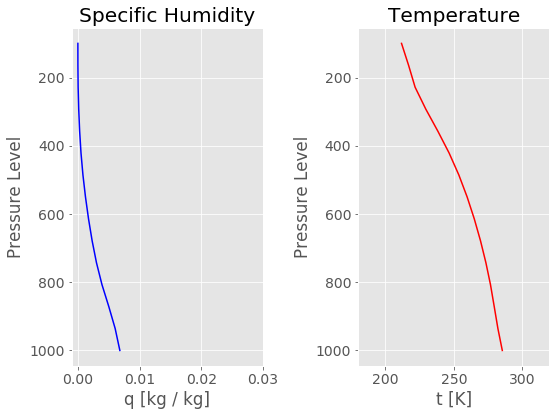

In [10]:
f, axs = plt.subplots(1, 2)

axs[0].set_ylabel("Pressure Level")
axs[0].set_xlabel("q [kg / kg]")
axs[0].set_title("Specific Humidity")
axs[0].invert_yaxis()
axs[0].plot(q_mean.ravel(), p_interp, c = 'b')
axs[0].set_xlim([-0.001, 0.03])

axs[1].set_ylabel("Pressure Level")
axs[1].set_xlabel("t [K]")
axs[1].set_title("Temperature")
axs[1].invert_yaxis()
axs[1].plot(t_mean.ravel(), p_interp, c = 'r')
axs[1].set_xlim([180, 320])

plt.tight_layout()

In [13]:
q_profiles

array([[  2.80056103e-06,   3.88733052e-06,   7.95067060e-06, ...,
          1.17311344e-03,   7.05359557e-04,   7.12011336e-04],
       [  2.80056103e-06,   3.58887043e-06,   7.01112359e-06, ...,
          1.47212093e-03,   8.09977180e-04,   7.88366261e-04],
       [  2.80056103e-06,   3.56745625e-06,   5.76374778e-06, ...,
          1.82255189e-03,   9.88519220e-04,   8.51136567e-04],
       ..., 
       [  1.86369079e-06,   4.99417579e-06,   2.23396592e-05, ...,
          1.02723854e-02,   1.23902863e-02,   1.33920817e-02],
       [  1.86369079e-06,   5.76107101e-06,   2.10186721e-05, ...,
          9.83432092e-03,   1.22800301e-02,   1.42750819e-02],
       [  1.86369079e-06,   7.46617485e-06,   2.23664269e-05, ...,
          9.84472553e-03,   1.22764526e-02,   1.43584633e-02]])

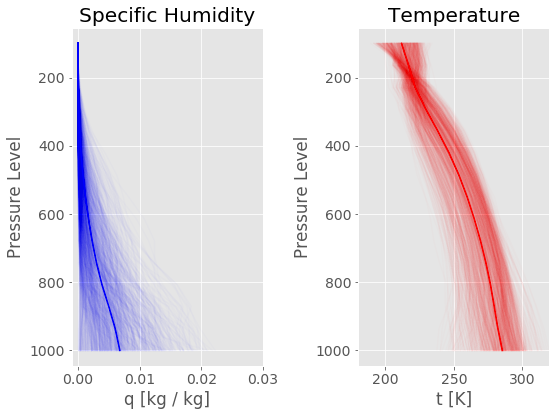

In [16]:
f, axs = plt.subplots(1, 2)
ps = np.arange(1, 28)[::-1]

axs[0].set_ylabel("Pressure Level")
axs[0].set_xlabel("q [kg / kg]")
axs[0].set_title("Specific Humidity")
axs[0].invert_yaxis()
axs[0].plot(q_mean.ravel(), p_interp, c = 'b')
for i in range(1000):
    ind = np.random.randint(0, q_profiles.shape[0])
    axs[0].plot(q_profiles[ind, :].ravel(), p_interp, c = 'b', alpha = 0.01)
axs[0].set_xlim([-0.001, 0.03])


axs[1].set_ylabel("Pressure Level")
axs[1].set_xlabel("t [K]")
axs[1].set_title("Temperature")
axs[1].invert_yaxis()
axs[1].plot(t_mean.ravel(), p_interp, c = 'r')
for i in range(1000):
    ind = np.random.randint(0, t_profiles.shape[0])
    axs[1].plot(t_profiles[ind, :].ravel(), p_interp, c = 'r', alpha = 0.01)
axs[1].set_xlim([180, 320])

plt.tight_layout()

### Covariance Matrices

In [3]:
q_profiles  = np.load("data/q_profiles.npy")
q_mean      = np.load("data/q_mean.npy")
t_profiles  = np.load("data/t_profiles.npy")
t_mean      = np.load("data/t_mean.npy")

In [18]:
q_log_cov = np.cov(np.log(np.maximum(q_profiles, 1e-9)) , rowvar = False)
t_cov = np.cov(np.maximum(t_profiles, 1e-9), rowvar = False)
np.save("data/q_log_cov", q_log_cov)
np.save("data/t_cov", t_cov)

In [19]:
q_log_mean = np.mean(np.log(np.maximum(q_profiles, 1e-9)), axis = 0)
t_log_mean = np.mean(np.log(np.maximum(t_profiles, 1e-9)), axis = 0)
np.save("data/q_log_mean", q_log_mean)
np.save("data/t_log_mean", t_log_mean)

### Combined Climatology

In [5]:
qt_profiles = np.concatenate([np.log(np.maximum(q_profiles, 1e-9)), t_profiles], axis = 1)
qt_mean     = np.mean(qt_profiles, axis = 0)
qt_cov      = np.cov(qt_profiles, rowvar = False)

In [6]:
np.save("data/qt_profiles", qt_profiles)
np.save("data/qt_cov", qt_cov)

In [7]:
np.save("data/qt_mean", qt_mean)